In [2]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import rescale
from numpy.linalg import norm

In [3]:
# name of the input file
imname = 'data/harvesters.tif'

# read in the image
im = skio.imread(imname)

In [4]:
# convert to double
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(np.int)

/var/folders/j3/z61mchl94r7_0hyhm9425phm0000gn/T/ipykernel_11259/3682824229.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  height = np.floor(im.shape[0] / 3.0).astype(np.int)


In [5]:
# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

In [6]:
# function that crops images by given percentage

def crop(image, perc_cropped):
    x_center, y_center = image.shape[1] / 2, image.shape[0] / 2
    horizontal, vertical = image.shape[1] * (1 - perc_cropped), image.shape[0] * (1 - perc_cropped)
    left, right = x_center - horizontal / 2, x_center + horizontal / 2
    top, bottom = y_center - vertical / 2, y_center + vertical / 2
    cropped_image = image[int(top):int(bottom), int(left):int(right)]
    
    return cropped_image

# crop all r, g, b channels by 15% 

r_crop = crop(r, 0.15)
g_crop = crop(g, 0.15)
b_crop = crop(b, 0.15)

In [7]:
# align func that returns optimal x and y displacement offset for two images

def align(im1, im2, func, min_x = 0, min_y = 0):
    
    if func == "euclid":
        usedfunc = euclid
    elif func == "ncc":
        usedfunc = ncc_align  
    elif func == "euclid_grad":
        usedfunc = euclid_grad 

    min_l2 = usedfunc(im1, im2)
    
    rangeshift = range(min_x - 10, min_x + 11)
    rangeshifty = range(min_y - 10, min_y + 11)
    
    for x in rangeshift:
        for y in rangeshifty:
            shifted_im1 = np.roll(im1, (x, y), axis = (1, 0))
            l2 = usedfunc(shifted_im1, im2)
            
            if l2 < min_l2:
                min_l2 = l2
                min_x, min_y = x, y
        
    return min_x, min_y

# l2 norm of RGB values
def euclid(im1, im2):
    return np.sqrt(np.sum(np.sum((im1 - im2) ** 2)))

# l2 norm of gradients
def euclid_grad(im1, im2):
    grad_x, grad_y = np.gradient(im1)
    grad_x2, grad_y2 = np.gradient(im2)
    return np.sqrt(np.sum(np.sum((grad_x - grad_x2) ** 2 + (grad_y - grad_y2) ** 2)))

# NCC of RGB values
def ncc_align(im1, im2):
    num = np.mean((im1 - im2.mean()) * (im1 - im2.mean()))
    denom = np.sqrt(np.sum((im1 - im1.mean()) ** 2) * np.sum((im2 - im2.mean()) ** 2))
    if denom == 0:
        return 0
    else:
        return num / denom

In [8]:
# recursive pyramid function; returns optimal offset

def pyramid(image, base_image, min_x, min_y):
    copy_image = np.copy(image)
    copy_base = np.copy(base_image)
    
    if copy_image.shape[0] < 128 or copy_image.shape[1] < 128:
        return align(copy_image, copy_base, "euclid_grad")
    
    downsized_image = sk.transform.rescale(copy_image, 1/2, anti_aliasing = True)
    downsized_base = sk.transform.rescale(copy_base, 1/2, anti_aliasing = True)

    min_x, min_y = np.multiply(pyramid(downsized_image, downsized_base, min_x, min_y), 2)

    return align(image, base_image, "euclid_grad", min_x, min_y)

In [9]:
# creates final images by rolling them by the optimal offset

def align_final(image1, base_image):
    retx, rety = pyramid(image1, base_image, 0, 0)
    print(f"optimal offset: {retx}, {rety}")
    final_im1 = np.roll(image1, (retx, rety), axis = (1, 0))
    return final_im1

ar = align_final(r_crop, b_crop)
ag = align_final(g_crop, b_crop)
ab = align_final(b_crop, b_crop)

im_out = np.dstack([ar, ag, ab])

optimal offset: 12, 123
optimal offset: 15, 60


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


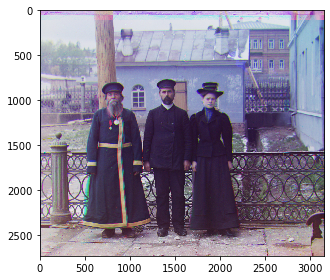

In [ ]:
# save the image
fname = 'out_fname.jpg'
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()